In [1]:
import zipfile

# Path to the zip file
zip_file_path = '/content/twitter_training.csv (1).zip'
# Directory where to extract
extract_to_dir = 'extracted_files/'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_to_dir)

print(f"Files extracted to {extract_to_dir}")

Files extracted to extracted_files/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
d=pd.read_csv("/content/twitter_training.csv (1).zip",   header=None,
                 names=["tweet_id", "entity", "sentiment", "text"])

d

,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [4]:
d.info()
print(d.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
['tweet_id', 'entity', 'sentiment', 'text']


In [5]:
print(d.isnull().sum())
d.duplicated().sum()

tweet_id       0
entity         0
sentiment      0
text         686
dtype: int64


np.int64(2700)

In [6]:
d.drop_duplicates(inplace=True)
d.duplicated().sum()

np.int64(0)

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

valid = ["Negative", "Neutral", "Positive"]
d = d[d["sentiment"].isin(valid)]

sent_map = {"Negative":0, "Neutral":1, "Positive":2}
d["label"] = d["sentiment"].map(sent_map)

# Fill NaN values in the 'text' column with empty strings before splitting
d["text"] = d["text"].fillna('')

X_train, X_test, y_train, y_test = train_test_split(
    d["text"], d["label"], test_size=0.2, random_state=42
)

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 40
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=20000, output_dim=64, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Explicitly build the model before printing the summary
model.build(input_shape=(None, max_len))
model.summary()

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

loss, acc = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", acc)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290,435 (4.92 MB)

 Trainable params: 1,290,435 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5102 - loss: 0.9697 - val_accuracy: 0.7478 - val_loss: 0.6275
Epoch 2/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8296 - loss: 0.4469 - val_accuracy: 0.8179 - val_loss: 0.4783
Epoch 3/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.9086 - loss: 0.2378 - val_accuracy: 0.8431 - val_loss: 0.4549
Epoch 4/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.9350 - loss: 0.1610 - val_accuracy: 0.8360 - val_loss: 0.4810
Epoch 5/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9449 - loss: 0.1324 - val_accuracy: 0.8287 - val_loss: 0.4801
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8235 - loss: 0.4879
Test Accuracy: 0.8198395371437073


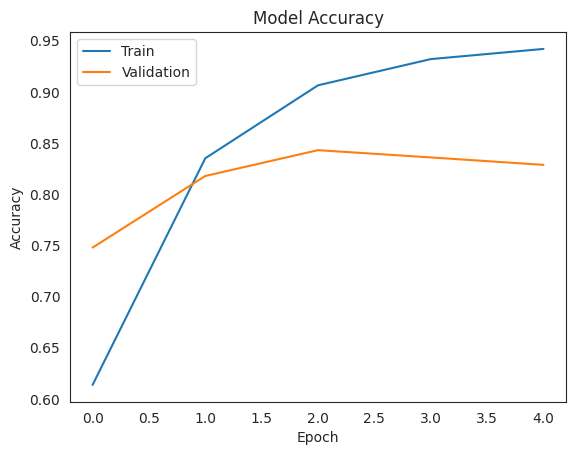

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

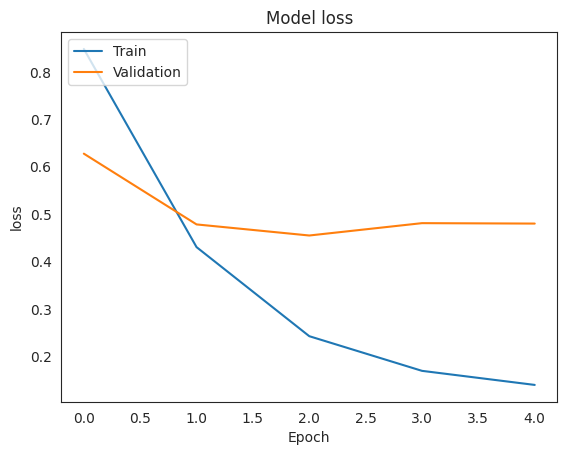

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


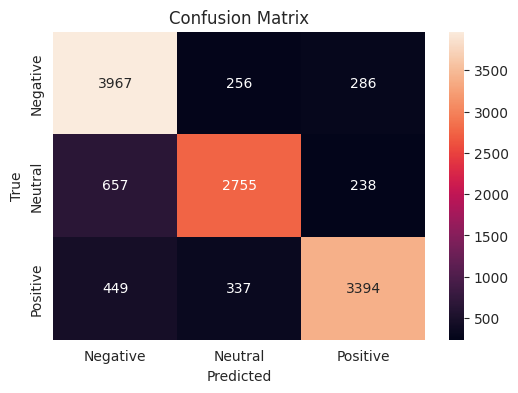

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      4509
           1       0.82      0.75      0.79      3650
           2       0.87      0.81      0.84      4180

    accuracy                           0.82     12339
   macro avg       0.82      0.82      0.82     12339
weighted avg       0.82      0.82      0.82     12339



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_labels))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,LSTM

model = Sequential([
    Embedding(input_dim=20000, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Explicitly build the model before printing the summary
model.build(input_shape=(None, max_len))
model.summary()

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

loss, acc = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", acc)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,203 (5.02 MB)

 Trainable params: 1,315,203 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.4388 - loss: 1.0176 - val_accuracy: 0.7350 - val_loss: 0.6405
Epoch 2/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7903 - loss: 0.5358 - val_accuracy: 0.8289 - val_loss: 0.4457
Epoch 3/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.8881 - loss: 0.3088 - val_accuracy: 0.8531 - val_loss: 0.4125
Epoch 4/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.9089 - loss: 0.2348 - val_accuracy: 0.8486 - val_loss: 0.3918
Epoch 5/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - accuracy: 0.9195 - loss: 0.1942 - val_accuracy: 0.8596 - val_loss: 0.4103
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8555 - loss: 0.4203
Test Accuracy: 0.8574438691139221


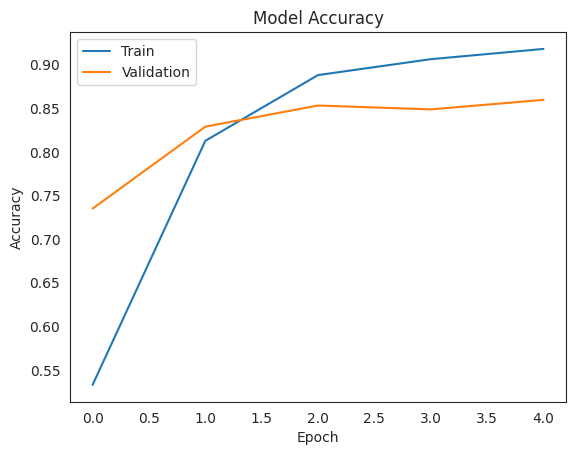

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

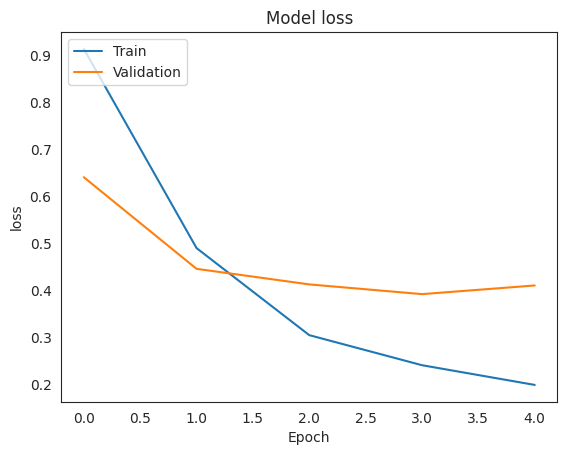

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


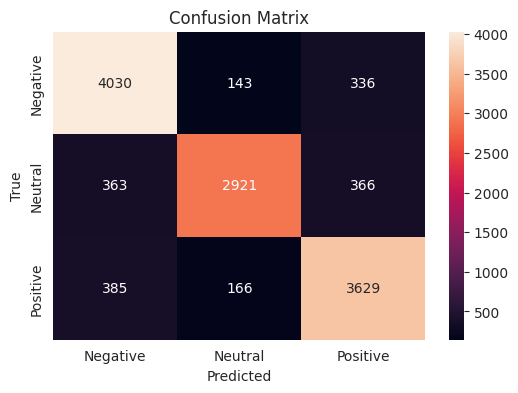

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4509
           1       0.90      0.80      0.85      3650
           2       0.84      0.87      0.85      4180

    accuracy                           0.86     12339
   macro avg       0.86      0.85      0.86     12339
weighted avg       0.86      0.86      0.86     12339



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_labels))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,LSTM,Bidirectional

model = Sequential([
    Embedding(input_dim=20000, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)), # Fix: Wrap LSTM layer within Bidirectional
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Explicitly build the model before printing the summary
model.build(input_shape=(None, max_len))
model.summary()

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

loss, acc = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", acc)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,350,275 (5.15 MB)

 Trainable params: 1,350,275 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.5917 - loss: 0.8554 - val_accuracy: 0.8135 - val_loss: 0.4798
Epoch 2/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.8724 - loss: 0.3326 - val_accuracy: 0.8545 - val_loss: 0.3710
Epoch 3/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9191 - loss: 0.2011 - val_accuracy: 0.8736 - val_loss: 0.3392
Epoch 4/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.9392 - loss: 0.1488 - val_accuracy: 0.8841 - val_loss: 0.3501
Epoch 5/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.9468 - loss: 0.1242 - val_accuracy: 0.8804 - val_loss: 0.3634
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8753 - loss: 0.3588
Test Accuracy: 0.8785153031349182


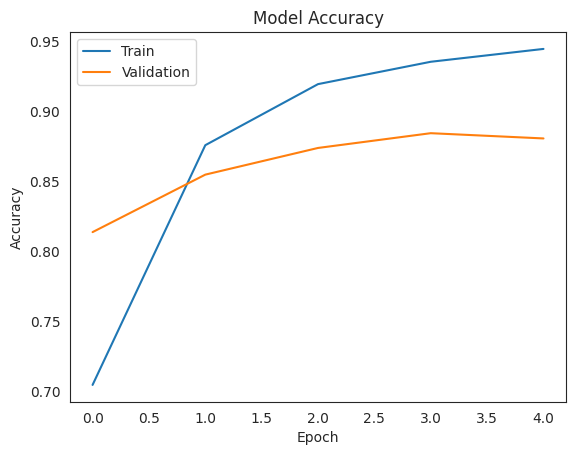

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

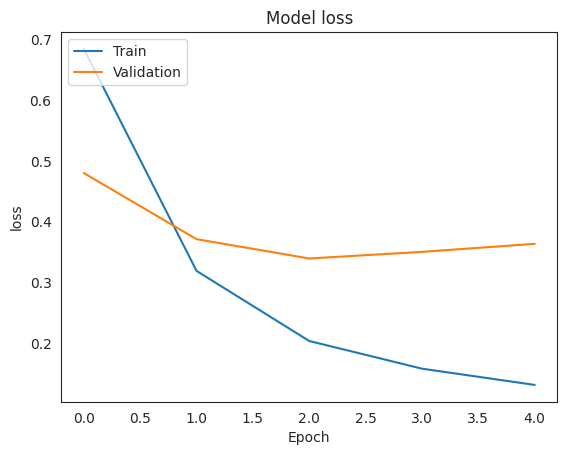

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


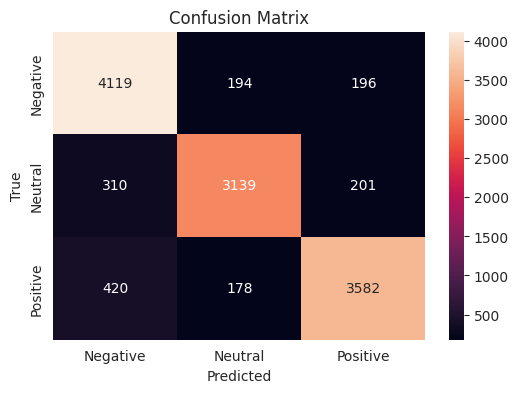

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4509
           1       0.89      0.86      0.88      3650
           2       0.90      0.86      0.88      4180

    accuracy                           0.88     12339
   macro avg       0.88      0.88      0.88     12339
weighted avg       0.88      0.88      0.88     12339



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_labels))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,LSTM,Bidirectional,GRU

model = Sequential([
    Embedding(input_dim=20000, output_dim=64, input_length=max_len),
   GRU(64, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Explicitly build the model before printing the summary
model.build(input_shape=(None, max_len))
model.summary()

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

loss, acc = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", acc)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,307,139 (4.99 MB)

 Trainable params: 1,307,139 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.3971 - loss: 1.0670 - val_accuracy: 0.6952 - val_loss: 0.7276
Epoch 2/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.7810 - loss: 0.5451 - val_accuracy: 0.8447 - val_loss: 0.4038
Epoch 3/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.8992 - loss: 0.2565 - val_accuracy: 0.8717 - val_loss: 0.3523
Epoch 4/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.9259 - loss: 0.1803 - val_accuracy: 0.8723 - val_loss: 0.3606
Epoch 5/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.9370 - loss: 0.1492 - val_accuracy: 0.8808 - val_loss: 0.3549
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8699 - loss: 0.3719
Test Accuracy: 0.8728421926498413


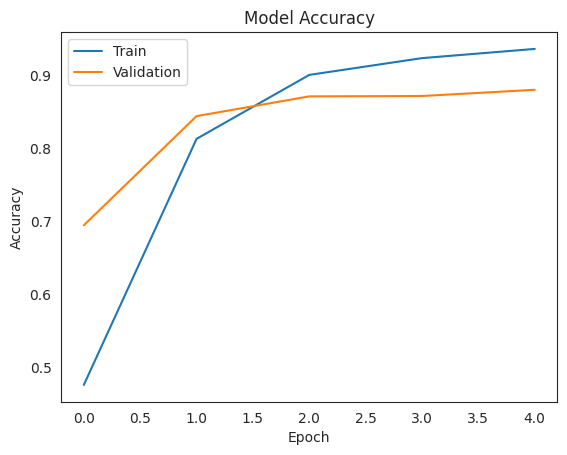

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

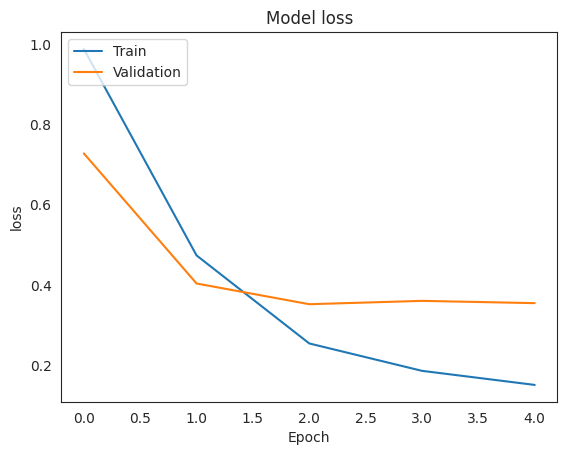

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


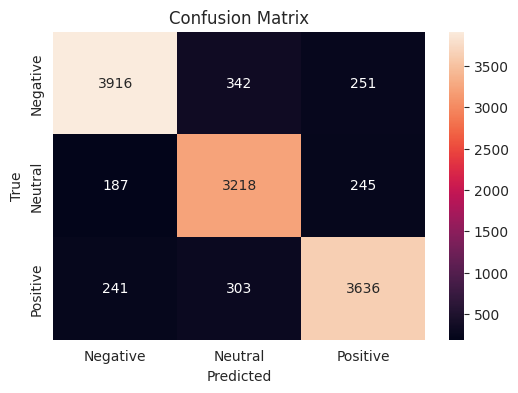

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4509
           1       0.83      0.88      0.86      3650
           2       0.88      0.87      0.87      4180

    accuracy                           0.87     12339
   macro avg       0.87      0.87      0.87     12339
weighted avg       0.87      0.87      0.87     12339



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_labels))